In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
from rbvfit import model as m 

In [2]:
samples = np.loadtxt('slurm_sample_results_1cld_.csv',delimiter = ',')
ev_arr = np.loadtxt('slurm_sample_results_1cld_ev_.csv',delimiter = ',')

# Now that we have our results from the slurm_sample job, lets go over some ways we can analyze our results

## First, in order to get a sense on how well the samples "converged" to an estimate, lets look at the corner plots

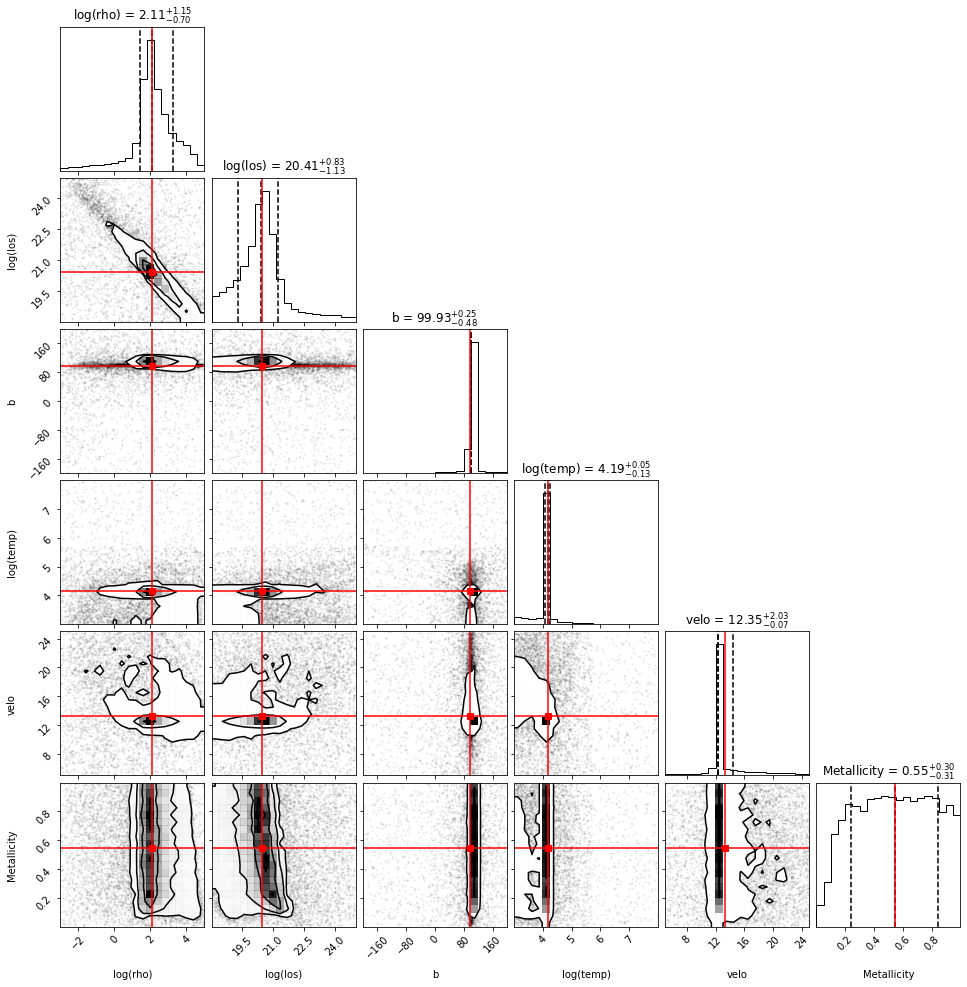

In [3]:
import corner

ndim = 6
# This is the empirical mean of the sample:
value2 = np.mean(samples, axis=0)

# Make the base corner plot
figure = corner.corner(samples, labels=['log(rho)','log(los)','b','log(temp)','velo','Metallicity'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value2[i], color="r")
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value2[xi], color="r")
        ax.axhline(value2[yi], color="r")
        ax.plot(value2[xi], value2[yi], "sr")

### So everything looks pretty good, but the log rho and log los dont seem to have converged so well. This is becuase to obtain our logN we essentially multiplied them together. So were only really checking the product of these two samples and not their respective values (note the diagonal histogram in the second line). This unfortunately I can no longer help with! It is now up to you!

# We can compare our logN value as well

In [4]:
guess_rho = samples[-1,0]
guess_los = samples[-1,1]
guess_b = samples[-1,2]
guess_logtemp = samples[-1,3]
guess_v = samples[-1,4]
guess_met = samples[-1,5]
#this takes the respective parameters from the last set of samples -> our best guess

In [5]:
total_N = 2.51188643e+22 # this is the true value from the previous notebook!
total_logN = np.log10(total_N)

In [6]:
guess_N = 10**(guess_rho) * 10**(guess_los)
guess_logN = np.log10(guess_N)

In [7]:
total_logN,guess_logN

(22.399999999739, 22.628260308664856)

### Not too bad! but we dont get the full picture with just these two values. The better way to check will be to plot the guess value vs the true value and include the standard deviation of our guess as error bars. Note this type of analysis is only possible when we are working with synthetic spectra

In [8]:
rho_sd = np.std(samples[:,0])
los_sd = np.std(samples[:,1])
logN_sd = (rho_sd + los_sd) / 2 # this is just the mean of the two SD's. works for now not the actual number we want to use in the long run

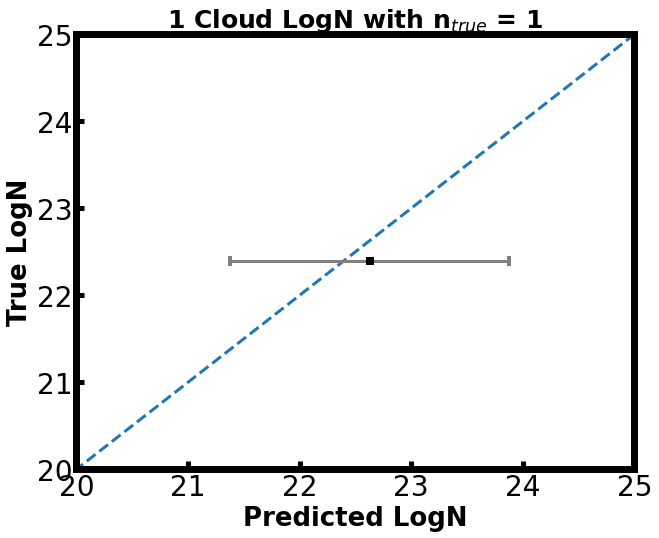

In [9]:
x = np.linspace(0, 40, 1000) #will help set diagonal
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("1 Cloud LogN with n$_{true}$ = 1",fontsize=25,fontweight="bold")

ax.plot(x,x+0,'--',linewidth=3)
plt.errorbar(guess_logN,total_logN,xerr=logN_sd, marker='s', mfc='black',ecolor='gray',elinewidth=3,capsize=5,
         mec='black', ms=4, mew=4,linestyle='none')
ax.set_xlim(20.,25)
ax.set_ylim(20.,25)

ax.set_ylabel('True LogN',fontsize=26,fontweight="bold")
ax.set_xlabel('Predicted LogN',fontsize=26,fontweight="bold")  
ax.xaxis.set_tick_params(direction='in',labelsize=28,size =8,width = 5)
ax.yaxis.set_tick_params(direction='in',labelsize=28,size =8, width = 5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(7)

### The way this plot reads is that any data point along the diagonal line is a true recovery of the logN, our guess is to the right of that line (over estimated) but our error bars (standard deviation) touch the line. Meaning the true answer lies within one standard deviation of our estimate

# Evidence Comparison

## We can also see how our evidence progressed over time and how our highest evidence compares with other runs (obviously will become more interesting once we have more runs)

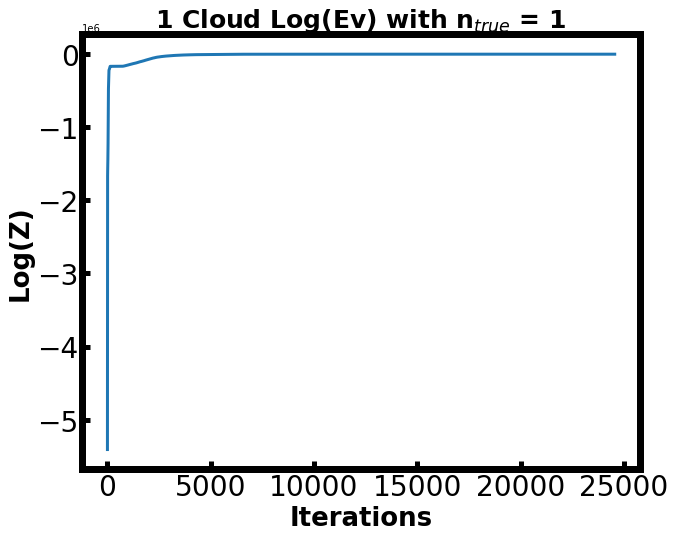

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("1 Cloud Log(Ev) with n$_{true}$ = 1",fontsize=25,fontweight="bold")

ax.plot(ev_arr,linewidth = 3)


ax.set_ylabel('Log(Z)',fontsize=26,fontweight="bold")
ax.set_xlabel('Iterations',fontsize=26,fontweight="bold")  
ax.xaxis.set_tick_params(direction='in',labelsize=28,size =8,width = 5)
ax.yaxis.set_tick_params(direction='in',labelsize=28,size =8, width = 5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(7)

In [23]:
ev_sd = np.std(ev_arr[-1000:])

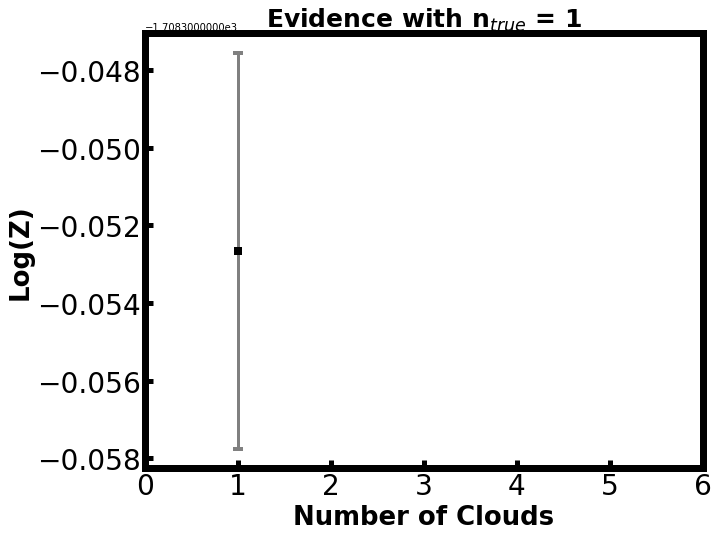

In [36]:
# more useful to plot like this with other samples
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Evidence with n$_{true}$ = 1",fontsize=25,fontweight="bold")

plt.errorbar(1.0,ev_arr[-1],yerr=ev_sd, marker='s', mfc='black',ecolor='gray',elinewidth=3,capsize=5,
         mec='black', ms=4, mew=4,linestyle='none')

ax.set_xlim(0,6)

ax.set_ylabel('Log(Z)',fontsize=26,fontweight="bold")
ax.set_xlabel('Number of Clouds',fontsize=26,fontweight="bold")  
ax.xaxis.set_tick_params(direction='in',labelsize=28,size =8,width = 5)
ax.yaxis.set_tick_params(direction='in',labelsize=28,size =8, width = 5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(7)

## once we have more evidence with higher number of clouds, we can fill in the rest!

# Fits

## Other than evidence comparison, this will tell us how well our sampling did

In [39]:
def frac_from_dens(redshift,density,temp,species,ion):  #useful function to produce ionization fraction
    
    cloudy = np.load('cloudy_table.npz')   #load table

    table = cloudy['table']
    #[redshift,density,temperature,species,ion]#
    
    rrange = np.arange(7,-1,-1) #redshift range from S Bird Cloudy tables
    trange = np.arange(3.,8.6,0.05) #temp range from S Bird Cloudy tables
    drange = np.arange(-7.,4.,0.2) #drange range from S Bird Cloudy tables
    
    spec = np.array(["H", "He", "C", "N", "O", "Ne", "Mg", "Si", "Fe"])
    
    trange = trange.round(3) #formatting necessary to read table

    r = np.where(rrange == redshift)
    t = np.where(trange == temp)
    el = np.where(spec == species)
    
    r = int(r[0])
    t = int(t[0])
    el = int(el[0])
    
    ion = ion-1 #account for formatting of np arrays
    
    frac = []
    for i in range (len(drange)):
        frac.append(table[r,i,t,el,ion])
    frac = np.array(frac)
    frac = 10**(frac)
    
    frac_dens = np.interp(density,drange,frac)
    
    return frac_dens



def gen_logN_arr(log_rho,log_los,log_temp,Met,elmnt,ion):
    """
    This function generates a logN array based off the set of samples dynesty will feed it. We will call it in our gen_model function 
    ____________________________________________________________________________________________________________________________________
    
        log(rho) = array of log 3D density values
        log_los = array of log of the length of line of sight values
        log_temp = array of log temperature values
        Met = array of metallicity values
        elmnt = array of element names. Must be given as strings in their atomic symbols. i.e. elmnt = ['Si','Mg'] for silicon and magnesium
        ion = array of corresponding ion numbers 
    
    """
    N_tot = 10**(log_rho)*10**(log_los)
    log_temp = np.round(log_temp,1)
    f_solar_H = 1
    f_solar_He = 8.33*10**(-2)
    f_solar_C =  10**(-3.45)
    f_solar_N = 10**(-3.95)
    f_solar_O = 10**(-3.28)
    f_solar_Ne = 10**(-3.95)
    f_solar_Mg = 10. ** (-9.22)
    f_solar_Si = 3.24 * 10.**(-4.48)
    f_solar_Fe = 10.**(-4.53)
    
    logN_arr = []
    for i in range (len(elmnt)):
        N = 0
        
        if (elmnt[i] == 'H'):
            f_ion = f_solar_H
        elif (elmnt[i] == 'He'):
            f_ion = f_solar_He
        elif (elmnt[i] == 'C'):
            f_ion = f_solar_C
        elif (elmnt[i] == 'N'):
            f_ion = f_solar_N
        elif (elmnt[i] == 'O'):
            f_ion = f_solar_O
        elif (elmnt[i] == 'Ne'):
            f_ion = f_solar_Ne
        elif (elmnt[i] == 'Mg'):
            f_ion = f_solar_Mg
        elif (elmnt[i] == 'Si'):
            f_ion = f_solar_Si
        elif (elmnt[i] == 'Fe'):
            f_ion = f_solar_Fe
        else:
            continue
        for j in range (n_clouds):
            f = frac_from_dens(0,log_rho[j],log_temp[j],elmnt[i],ion[i]) * f_ion
            N += N_tot * f * Met
        lgN = np.log10(N)
        logN_arr.append(lgN)
    
    logN_arr = np.array(logN_arr)
    logN_arr = logN_arr.ravel() #makes array 1-D
    logN_arr = logN_arr.reshape(len(lambda_rest),n_clouds)
    return logN_arr





def compile_model(log_rho,log_los,v,log_temp,b,Met,elmnt,ion):
    
    """ 
    This function takes the logN array as well as velo and doppler b to create our flux model at each rest wavelength
    """
    
    logN_arr = gen_logN_arr(log_rho,log_los,log_temp,Met,elmnt,ion)
    outflx = []
    for i in range (len(lambda_rest)):
        for j in range (n_clouds):
            theta = np.array([logN_arr[i,j],b[j],v[j]])
            nclump = n_clouds
            s= m.create_voigt(zabs,[lambda_rest[i]],nclump,1,FWHM = '6.5',verbose=True)
            flx = s.model_flux(theta,wave)
            outflx.append(flx)
    tau = -np.log(outflx)
    op_depth_arr = np.sum(tau,axis =0)
    model = np.exp(-op_depth_arr)
    
    return model

In [42]:
flux = np.loadtxt('flux_cloudy.csv',delimiter = ',')
wave = np.loadtxt('wave_cloudy.csv',delimiter= ',')

In [43]:
n_clouds =1
lambda_rest  = np.array([1845.5202, 1526.7066,2026.4768,2796.352])
redshift = np.array([0.0])  #necessary input parameter for CLOUDY 
zabs = redshift
species = np.array(['Si','Si','Mg','Mg'])
ion = np.array([1,2,1,2])   #Accounts for Si I,II and MgI,II          

In [45]:
guess = samples[-1]
guess_rho = np.array([guess[0]])
guess_los = np.array([guess[1]])
guess_v = np.array([guess[2]])
guess_temp = np.array([guess[3]])
guess_b = np.array([guess[4]])
guess_met = np.array([guess[5]])
guess_flux = compile_model(guess_rho,guess_los,guess_v,guess_temp,guess_b,guess_met,species,ion)

Added line:SiI 1845 at z:0.0
Added line:SiII 1526 at z:0.0
Added line:MgI 2026 at z:0.0
Added line:MgII 2796 at z:0.0


/scratch/local/44329849/ipykernel_50669/1371507797.py:117: RuntimeWarning: divide by zero encountered in log
  tau = -np.log(outflx)


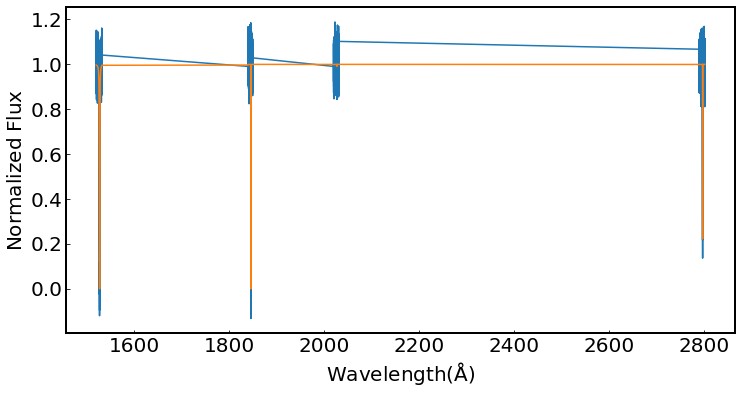

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
    
ax.plot(wave,flux,label='Mock Spectrum')
ax.plot(wave,guess_flux,label='Fit')
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 

In [47]:
# or plot this to zoom in 
c = 3*10**5  # speed of light in km/s

velo1 = c*(  (wave-lambda_rest[0]) / lambda_rest[0] )  #doppler equation  
velo2 = c*(  (wave-lambda_rest[1]) / lambda_rest[1] )  
velo3 = c*(  (wave-lambda_rest[2]) / lambda_rest[2] ) 
velo4 = c*(  (wave-lambda_rest[3]) / lambda_rest[3] ) 

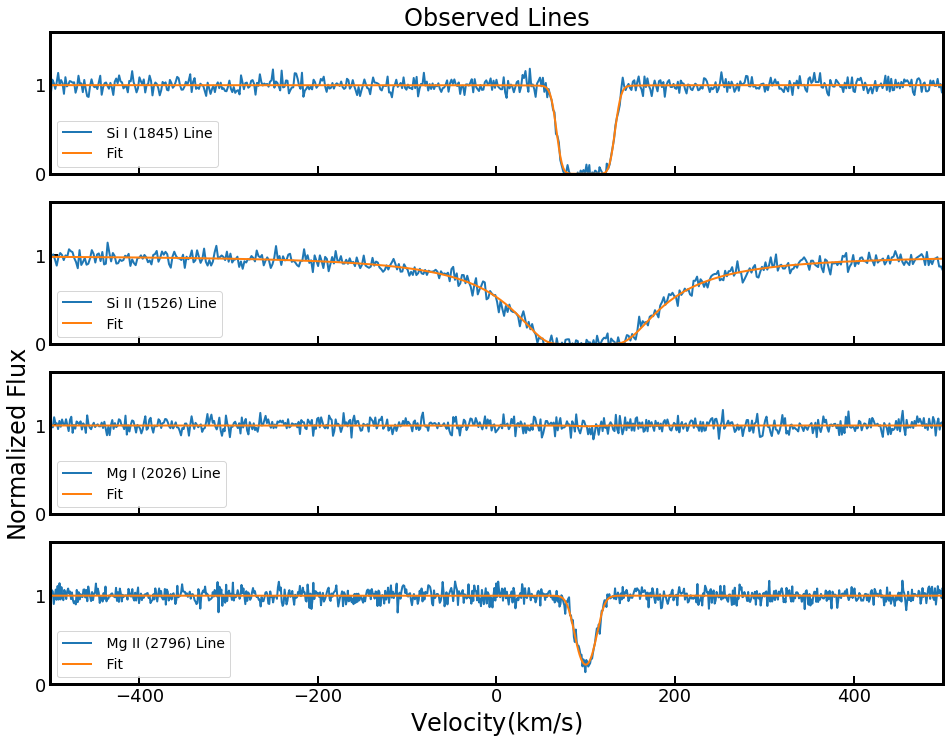

In [48]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, sharex=True,figsize= (16,12))

ax1.set_title("Observed Lines",fontsize = 24)
    

ax1.plot(velo1,flux, label=' Si I (1845) Line',linewidth=2)
ax2.plot(velo2,flux, label=' Si II (1526) Line',linewidth=2)
ax3.plot(velo3,flux, label=' Mg I (2026) Line',linewidth=2)
ax4.plot(velo4,flux, label=' Mg II (2796) Line',linewidth=2)

ax1.plot(velo1,guess_flux, label=' Fit',linewidth=2)
ax2.plot(velo2,guess_flux, label=' Fit',linewidth=2)
ax3.plot(velo3,guess_flux, label=' Fit',linewidth=2)
ax4.plot(velo4,guess_flux, label=' Fit',linewidth=2)

ax1.set_xlim(-500,500)

ax1.set_ylim(0,1.6)
ax2.set_ylim(0,1.6)
ax3.set_ylim(0,1.6)
ax4.set_ylim(0,1.6)

ax1.legend(fontsize='14')
ax2.legend(fontsize='14')
ax3.legend(fontsize='14',loc=3)
ax4.legend(fontsize='14')
ax3.set_ylabel(r'$\mathrm{Normalized\;Flux}$',fontsize=24)
ax4.set_xlabel(r'$\mathrm{Velocity (km/s)}$',fontsize=24)
ax1.xaxis.set_tick_params(direction='in',size=8,width=2)
ax1.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax2.xaxis.set_tick_params(direction='in',size=8,width=2)
ax2.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax3.xaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax3.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax4.xaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax4.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(3)
    ax2.spines[axis].set_linewidth(3)
    ax3.spines[axis].set_linewidth(3)
    ax4.spines[axis].set_linewidth(3)

# Our fit turned out pretty well even though our estimates of the parameters were not exactly correct. This highlights the degeneracy of our problem and should hopefully be the next obstacle to tackle. I leave that to you! One possible and necessary solution is to run the same sample multiple times to average out the randomness of the sampling. The results will look the same except there will be a different 